<a href="https://colab.research.google.com/github/elijahmflomo/Sem_2_ADVANCED-REINFORCEMENT-LEARNING/blob/main/2506B09602_MSC_RL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1. Scenario: Online Advertisement Selection
A company displays 3 online advertisements (Ad A, Ad B, Ad C) on
its website. Each time a user visits, the system selects one ad and
observes whether the user clicks (reward = 1) or does not click (reward
= 0).
Tasks:
1. Model this problem as a Multi-Armed Bandit by identifying the
arms and rewards.
2. Implement the ε-Greedy algorithm with ε = 0.1 for 1000 rounds.
3. Implement the Upper Confidence Bound (UCB) method for the
same setting.
4. Implement Thompson Sampling assuming Bernoulli rewards.
5. Compare the average reward obtained by each algorithm. 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup the Environment
class AdEnvironment:
    def __init__(self, true_ctrs):
        self.true_ctrs = true_ctrs  # e.g., [0.05, 0.12, 0.08]
        self.n_arms = len(true_ctrs)

    def get_reward(self, arm_index):
        # Bernoulli trial: returns 1 with probability true_ctrs[arm_index]
        return 1 if np.random.random() < self.true_ctrs[arm_index] else 0

# 2. Implement Algorithms
def run_mab_simulation(env, rounds=1000, epsilon=0.1):
    n_arms = env.n_arms

    # Storage for results
    results = {'E-Greedy': [], 'UCB': [], 'Thompson': []}

    # --- Epsilon-Greedy ---
    Q_eg = np.zeros(n_arms) # Estimated rewards
    N_eg = np.zeros(n_arms) # Pull counts
    rewards_eg = []

    # --- UCB ---
    Q_ucb = np.zeros(n_arms)
    N_ucb = np.zeros(n_arms)
    rewards_ucb = []

    # --- Thompson Sampling ---
    alphas = np.ones(n_arms) # Prior successes
    betas = np.ones(n_arms)  # Prior failures
    rewards_ts = []

    for t in range(1, rounds + 1):
        # A. E-Greedy Selection
        if np.random.random() < epsilon:
            arm_eg = np.random.randint(n_arms)
        else:
            arm_eg = np.argmax(Q_eg)

        # B. UCB Selection
        if t <= n_arms: # Initial rounds: try each once
            arm_ucb = t - 1
        else:
            ucb_values = Q_ucb + np.sqrt(2 * np.log(t) / N_ucb)
            arm_ucb = np.argmax(ucb_values)

        # C. Thompson Sampling Selection
        samples = [np.random.beta(alphas[i], betas[i]) for i in range(n_arms)]
        arm_ts = np.argmax(samples)

        # Update Environment and Agents
        for arm, algo in [(arm_eg, 'EG'), (arm_ucb, 'UCB'), (arm_ts, 'TS')]:
            reward = env.get_reward(arm)
            if algo == 'EG':
                N_eg[arm] += 1
                Q_eg[arm] += (reward - Q_eg[arm]) / N_eg[arm]
                rewards_eg.append(reward)
            elif algo == 'UCB':
                N_ucb[arm] += 1
                Q_ucb[arm] += (reward - Q_ucb[arm]) / N_ucb[arm]
                rewards_ucb.append(reward)
            else:
                if reward == 1: alphas[arm] += 1
                else: betas[arm] += 1
                rewards_ts.append(reward)

    return rewards_eg, rewards_ucb, rewards_ts

# Run Simulation
true_ctrs = [0.05, 0.12, 0.08]
env = AdEnvironment(true_ctrs)
re_eg, re_ucb, re_ts = run_mab_simulation(env)

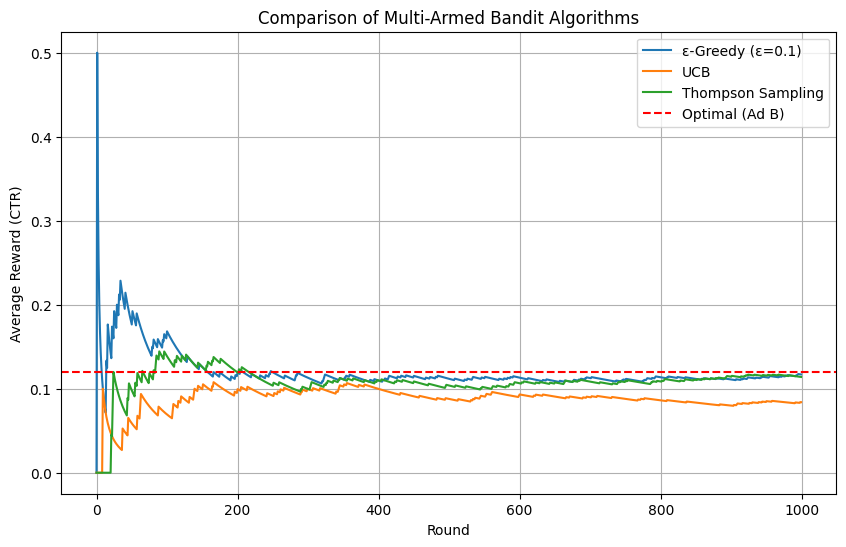

In [2]:
def plot_comparison(re_eg, re_ucb, re_ts):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(re_eg) / (np.arange(1000) + 1), label='ε-Greedy (ε=0.1)')
    plt.plot(np.cumsum(re_ucb) / (np.arange(1000) + 1), label='UCB')
    plt.plot(np.cumsum(re_ts) / (np.arange(1000) + 1), label='Thompson Sampling')
    plt.axhline(y=0.12, color='r', linestyle='--', label='Optimal (Ad B)')
    plt.title("Comparison of Multi-Armed Bandit Algorithms")
    plt.xlabel("Round")
    plt.ylabel("Average Reward (CTR)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparison(re_eg, re_ucb, re_ts)

Task 2. Scenario: Slot Machine Game
A player is playing a casino game with 4 slot machines. Each machine
gives a reward of 1 with an unknown probability and 0 otherwise.
Tasks:
1. Explain why this problem fits the Multi-Armed Bandit
framework.
2. Use ε-Greedy (ε = 0.2) to estimate the best machine over 500
trials.
3. Apply the UCB algorithm to select machines.
4. Use Thompson Sampling with Beta priors.
5. Identify which algorithm learns the best machine faster.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Environment Setup (4 Slot Machines)
class CasinoEnvironment:
    def __init__(self, probabilities):
        self.probs = probabilities # Unknown to the algorithms
        self.n_arms = len(probabilities)

    def pull_arm(self, arm_index):
        return 1 if np.random.random() < self.probs[arm_index] else 0

# 2. Solver Logic
def solve_slot_machines(env, trials=500, epsilon=0.2):
    n_arms = env.n_arms

    # Data structures for tracking
    eg_rewards, ucb_rewards, ts_rewards = [], [], []

    # E-Greedy Stats
    Q_eg, N_eg = np.zeros(n_arms), np.zeros(n_arms)

    # UCB Stats
    Q_ucb, N_ucb = np.zeros(n_arms), np.zeros(n_arms)

    # Thompson Stats (Beta Priors: alpha=1, beta=1 is a uniform distribution)
    alphas, betas = np.ones(n_arms), np.ones(n_arms)

    for t in range(1, trials + 1):
        # --- ε-Greedy (ε=0.2) ---
        if np.random.random() < epsilon:
            arm_eg = np.random.randint(n_arms)
        else:
            arm_eg = np.argmax(Q_eg)

        r_eg = env.pull_arm(arm_eg)
        N_eg[arm_eg] += 1
        Q_eg[arm_eg] += (r_eg - Q_eg[arm_eg]) / N_eg[arm_eg]
        eg_rewards.append(r_eg)

        # --- UCB ---
        if t <= n_arms:
            arm_ucb = t - 1
        else:
            # UCB formula: Average + Confidence Interval
            ucb_vals = Q_ucb + np.sqrt(2 * np.log(t) / N_ucb)
            arm_ucb = np.argmax(ucb_vals)

        r_ucb = env.pull_arm(arm_ucb)
        N_ucb[arm_ucb] += 1
        Q_ucb[arm_ucb] += (r_ucb - Q_ucb[arm_ucb]) / N_ucb[arm_ucb]
        ucb_rewards.append(r_ucb)

        # --- Thompson Sampling ---
        samples = [np.random.beta(alphas[i], betas[i]) for i in range(n_arms)]
        arm_ts = np.argmax(samples)

        r_ts = env.pull_arm(arm_ts)
        if r_ts == 1: alphas[arm_ts] += 1
        else: betas[arm_ts] += 1
        ts_rewards.append(r_ts)

    return eg_rewards, ucb_rewards, ts_rewards

# Initialize with one machine clearly better than the others
# Machine 3 (index 2) is the "winner" with 60% win rate
casino = CasinoEnvironment([0.1, 0.2, 0.6, 0.3])
eg, ucb, ts = solve_slot_machines(casino)

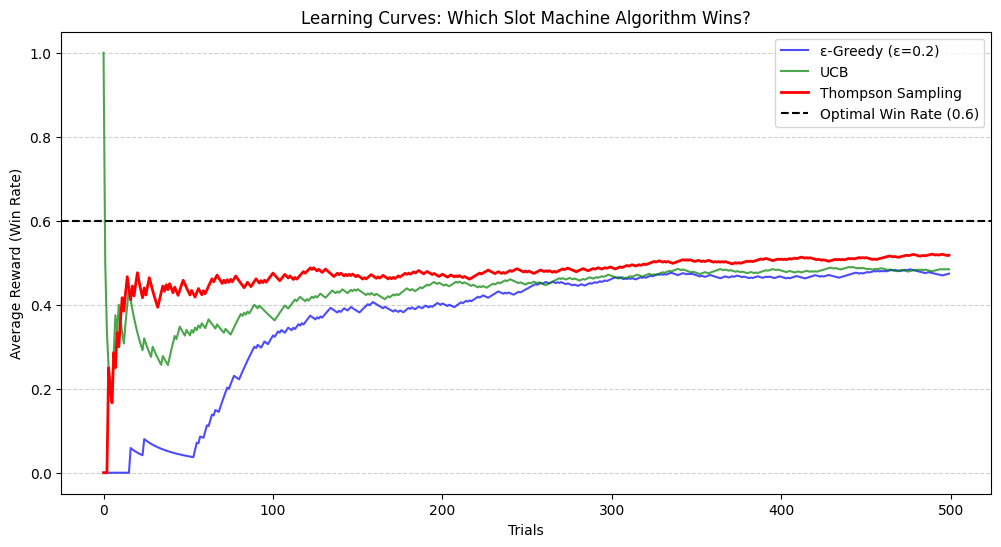

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Environment
class CasinoEnvironment:
    def __init__(self, probabilities):
        self.probs = probabilities
        self.n_arms = len(probabilities)

    def pull_arm(self, arm_index):
        return 1 if np.random.random() < self.probs[arm_index] else 0

# 2. Run Combined Simulation
def run_casino_study(probs, trials=500, epsilon=0.2):
    n_arms = len(probs)
    env = CasinoEnvironment(probs)

    # Trackers
    eg_history, ucb_history, ts_history = [], [], []

    # Agent Stats
    Q_eg, N_eg = np.zeros(n_arms), np.zeros(n_arms)
    Q_ucb, N_ucb = np.zeros(n_arms), np.zeros(n_arms)
    alphas, betas = np.ones(n_arms), np.ones(n_arms)

    for t in range(1, trials + 1):
        # --- Epsilon-Greedy ---
        arm_eg = np.random.randint(n_arms) if np.random.random() < epsilon else np.argmax(Q_eg)
        r_eg = env.pull_arm(arm_eg)
        N_eg[arm_eg] += 1
        Q_eg[arm_eg] += (r_eg - Q_eg[arm_eg]) / N_eg[arm_eg]
        eg_history.append(r_eg)

        # --- UCB ---
        if t <= n_arms:
            arm_ucb = t - 1
        else:
            arm_ucb = np.argmax(Q_ucb + np.sqrt(2 * np.log(t) / N_ucb))
        r_ucb = env.pull_arm(arm_ucb)
        N_ucb[arm_ucb] += 1
        Q_ucb[arm_ucb] += (r_ucb - Q_ucb[arm_ucb]) / N_ucb[arm_ucb]
        ucb_history.append(r_ucb)

        # --- Thompson Sampling ---
        arm_ts = np.argmax([np.random.beta(alphas[i], betas[i]) for i in range(n_arms)])
        r_ts = env.pull_arm(arm_ts)
        if r_ts == 1: alphas[arm_ts] += 1
        else: betas[arm_ts] += 1
        ts_history.append(r_ts)

    return eg_history, ucb_history, ts_history

# 3. Execution and Visualization
probs = [0.1, 0.2, 0.6, 0.3] # Machine 3 is the best
eg, ucb, ts = run_casino_study(probs)

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(eg) / (np.arange(500) + 1), label='ε-Greedy (ε=0.2)', color='blue', alpha=0.7)
plt.plot(np.cumsum(ucb) / (np.arange(500) + 1), label='UCB', color='green', alpha=0.7)
plt.plot(np.cumsum(ts) / (np.arange(500) + 1), label='Thompson Sampling', color='red', linewidth=2)
plt.axhline(y=max(probs), color='black', linestyle='--', label='Optimal Win Rate (0.6)')

plt.title("Learning Curves: Which Slot Machine Algorithm Wins?")
plt.xlabel("Trials")
plt.ylabel("Average Reward (Win Rate)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Task 3: A news app recommends 3 different articles to users. The reward is 1
if the user reads the article, otherwise 0.
Tasks:
1. Define the arms and reward structure for the bandit problem.
2. Simulate article selection using ε-Greedy with ε = 0.05.
3. Implement UCB and explain how exploration is handled.
4. Implement Thompson Sampling and update posterior
distributions.
5. Plot and compare the cumulative rewards of all three methods.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class NewsAppEnvironment:
    def __init__(self, ctrs):
        self.ctrs = ctrs  # True engagement rates for the 3 articles
        self.n_arms = len(ctrs)

    def get_user_response(self, arm_index):
        return 1 if np.random.random() < self.ctrs[arm_index] else 0

def simulate_news_recs(ctrs, rounds=1000, epsilon=0.05):
    n_arms = len(ctrs)
    env = NewsAppEnvironment(ctrs)

    # Trackers for Reward History
    eg_rewards, ucb_rewards, ts_rewards = [], [], []

    # E-Greedy/UCB State
    Q_eg, N_eg = np.zeros(n_arms), np.zeros(n_arms)
    Q_ucb, N_ucb = np.zeros(n_arms), np.zeros(n_arms)

    # Thompson Sampling State (Beta Priors)
    alphas, betas = np.ones(n_arms), np.ones(n_arms)

    for t in range(1, rounds + 1):
        # 2. E-Greedy (Epsilon = 0.05)
        arm_eg = np.random.randint(n_arms) if np.random.random() < epsilon else np.argmax(Q_eg)
        r_eg = env.get_user_response(arm_eg)
        N_eg[arm_eg] += 1
        Q_eg[arm_eg] += (r_eg - Q_eg[arm_eg]) / N_eg[arm_eg]
        eg_rewards.append(r_eg)

        # 3. UCB Implementation
        if t <= n_arms:
            arm_ucb = t - 1
        else:
            # UCB handles exploration via the uncertainty bonus (sqrt term)
            # As N_ucb[i] increases, the bonus shrinks, favoring exploitation
            ucb_vals = Q_ucb + np.sqrt(2 * np.log(t) / N_ucb)
            arm_ucb = np.argmax(ucb_vals)
        r_ucb = env.get_user_response(arm_ucb)
        N_ucb[arm_ucb] += 1
        Q_ucb[arm_ucb] += (r_ucb - Q_ucb[arm_ucb]) / N_ucb[arm_ucb]
        ucb_rewards.append(r_ucb)

        # 4. Thompson Sampling
        # Update Posterior: Beta(alpha + success, beta + failure)
        samples = [np.random.beta(alphas[i], betas[i]) for i in range(n_arms)]
        arm_ts = np.argmax(samples)
        r_ts = env.get_user_response(arm_ts)
        if r_ts == 1: alphas[arm_ts] += 1
        else: betas[arm_ts] += 1
        ts_rewards.append(r_ts)

    return eg_rewards, ucb_rewards, ts_rewards

# Define true Click-Through Rates for the articles
article_ctrs = [0.08, 0.18, 0.12] # Article 2 is the clear winner
eg, ucb, ts = simulate_news_recs(article_ctrs)

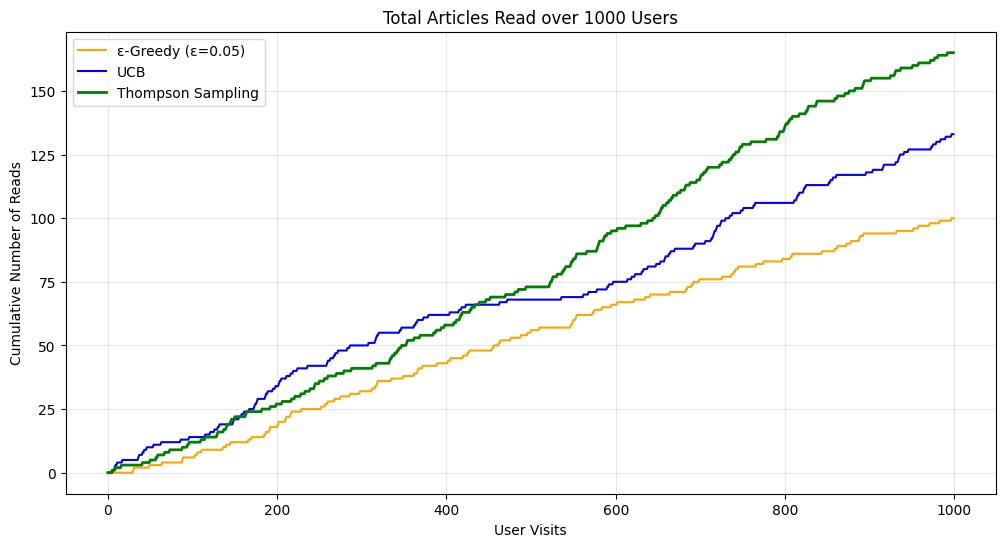

In [6]:
def plot_news_results(eg, ucb, ts):
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(eg), label='ε-Greedy (ε=0.05)', color='orange')
    plt.plot(np.cumsum(ucb), label='UCB', color='blue')
    plt.plot(np.cumsum(ts), label='Thompson Sampling', color='green', linewidth=2)

    plt.title("Total Articles Read over 1000 Users")
    plt.xlabel("User Visits")
    plt.ylabel("Cumulative Number of Reads")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_news_results(eg, ucb, ts)

Task 4: Scenario: Restaurant Dish Recommendation
A food delivery app recommends 4 dishes to new users.
Each recommendation receives positive feedback (1) or negative
feedback (0).
Tasks:
1. Formulate the problem as a Multi-Armed Bandit.
2. Implement ε-Greedy and observe the effect of different ε
values.
3. Apply the UCB algorithm to balance exploration and
exploitation.
4. Implement Thompson Sampling using Bernoulli rewards.
5. Compare the regret of all three algorithms.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

class RestaurantEnv:
    def __init__(self, order_rates):
        self.order_rates = order_rates
        self.n_arms = len(order_rates)

    def get_feedback(self, arm_index):
        return 1 if np.random.random() < self.order_rates[arm_index] else 0

def simulate_restaurant_mab(order_rates, rounds=1000):
    n_arms = len(order_rates)
    env = RestaurantEnv(order_rates)
    best_rate = max(order_rates)

    # Storage for Regret (Cumulative Difference from Best)
    regret = {'EG_01': [], 'EG_03': [], 'UCB': [], 'TS': []}

    # Initialize Agent States
    Q_01, N_01 = np.zeros(n_arms), np.zeros(n_arms)
    Q_03, N_03 = np.zeros(n_arms), np.zeros(n_arms)
    Q_ucb, N_ucb = np.zeros(n_arms), np.zeros(n_arms)
    alphas, betas = np.ones(n_arms), np.ones(n_arms)

    cum_regret_01, cum_regret_03, cum_regret_ucb, cum_regret_ts = 0, 0, 0, 0

    for t in range(1, rounds + 1):
        # --- E-Greedy (eps=0.1 vs eps=0.3) ---
        arm_01 = np.random.randint(n_arms) if np.random.random() < 0.1 else np.argmax(Q_01)
        arm_03 = np.random.randint(n_arms) if np.random.random() < 0.3 else np.argmax(Q_03)

        # --- UCB ---
        if t <= n_arms: arm_ucb = t - 1
        else: arm_ucb = np.argmax(Q_ucb + np.sqrt(2 * np.log(t) / N_ucb))

        # --- Thompson Sampling ---
        arm_ts = np.argmax([np.random.beta(alphas[i], betas[i]) for i in range(n_arms)])

        # Update and Calculate Regret
        for arm, algo in [(arm_01, '01'), (arm_03, '03'), (arm_ucb, 'UCB'), (arm_ts, 'TS')]:
            reward = env.get_feedback(arm)
            regret_val = best_rate - order_rates[arm] # Regret = Optimal - Actual

            if algo == '01':
                N_01[arm] += 1
                Q_01[arm] += (reward - Q_01[arm]) / N_01[arm]
                cum_regret_01 += regret_val
                regret['EG_01'].append(cum_regret_01)
            elif algo == '03':
                N_03[arm] += 1
                Q_03[arm] += (reward - Q_03[arm]) / N_03[arm]
                cum_regret_03 += regret_val
                regret['EG_03'].append(cum_regret_03)
            elif algo == 'UCB':
                N_ucb[arm] += 1
                Q_ucb[arm] += (reward - Q_ucb[arm]) / N_ucb[arm]
                cum_regret_ucb += regret_val
                regret['UCB'].append(cum_regret_ucb)
            else:
                if reward == 1: alphas[arm] += 1
                else: betas[arm] += 1
                cum_regret_ts += regret_val
                regret['TS'].append(cum_regret_ts)

    return regret

# Run simulation: One dish is highly popular (0.25)
rates = [0.05, 0.10, 0.25, 0.15]
regret_data = simulate_restaurant_mab(rates)

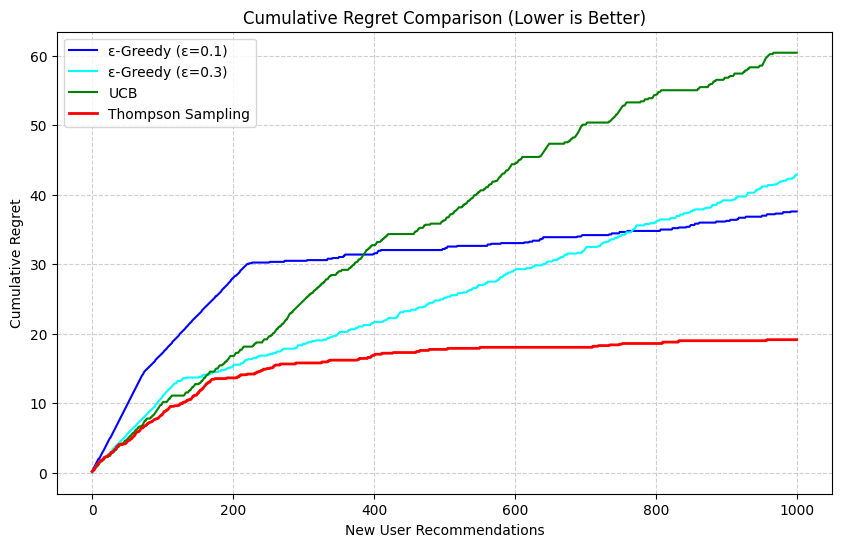

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(regret_data['EG_01'], label='ε-Greedy (ε=0.1)', color='blue')
plt.plot(regret_data['EG_03'], label='ε-Greedy (ε=0.3)', color='cyan')
plt.plot(regret_data['UCB'], label='UCB', color='green')
plt.plot(regret_data['TS'], label='Thompson Sampling', color='red', linewidth=2)

plt.title("Cumulative Regret Comparison (Lower is Better)")
plt.xlabel("New User Recommendations")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()